In [6]:
import numpy as np
import os
import mne
from mne.datasets import eegbci
from mne.io import read_raw_edf
from mne.time_frequency import tfr_array_morlet
from scipy.signal import detrend


subjects = [1, 2, 3, 4, 5]        # first 5 subjects
runs_to_fetch = [1, 4]            # baseline (1) and motor imagery (4)
channels_of_interest = ['C3..', 'Cz..', 'C4..', 'Fz..', 'Pz..', 'P3..', 'P4..']
data_path = os.path.expanduser('~/mne_data')

sfreq_target = 128.0
freqs = np.arange(4., 31., 1.)      # 4–30 Hz
n_cycles = freqs / 2.0
alpha_mask = (freqs >= 8) & (freqs <= 13)
win_sec = 2.0

# ---------------------------------------------
# DOWNLOADING ALL FILES FIRST
# ---------------------------------------------
all_files = {subj: eegbci.load_data(subj, runs_to_fetch, verbose=False)
             for subj in subjects}

# ---------------------------------------------
# DICTIONARY TO STORE RESULTS
# keys: (subject, run) → alpha-band coherence matrix
# ---------------------------------------------
alpha_coh_all = {}

# ---------------------------------------------
# OUTER LOOP: for each subject
# INNER LOOP: for each run
# ---------------------------------------------
for subj in subjects:
    print(f"\n=== Processing Subject {subj} ===")
    for run_idx, run_num in enumerate(runs_to_fetch):
        print(f"  Run {run_num}...")
        raw_fname = all_files[subj][run_idx]

        # ---------- Load & preprocess ----------
        raw = read_raw_edf(raw_fname, preload=True, verbose=False)
        print("Channels available:", raw.ch_names)

        raw.pick_types(eeg=True)
        picks = [ch for ch in channels_of_interest if ch in raw.ch_names]
        if len(picks) < 2:
            print("  Skipping — not enough channels found")
            continue

        raw.notch_filter(np.arange(50, 251, 50), picks=picks,
                         method='spectrum_fit', verbose=False)
        raw.filter(1., 40., picks=picks, fir_design='firwin', verbose=False)
        raw.resample(sfreq_target, npad='auto', verbose=False)

        # ---------- Epoch into 2-s windows ----------
        data = raw.get_data(picks=picks)
        n_ch, n_times = data.shape
        win_samples = int(win_sec * sfreq_target)
        n_windows = n_times // win_samples
        epochs = np.zeros((n_windows, n_ch, win_samples))
        for w in range(n_windows):
            seg = data[:, w*win_samples:(w+1)*win_samples]
            seg = detrend(seg, axis=1)
            epochs[w] = seg

        # ---------- Morlet wavelet transform ----------
        power_complex = tfr_array_morlet(
            epochs, sfreq=sfreq_target, freqs=freqs,
            n_cycles=n_cycles, output='complex', verbose=False)

        # ---------- Wavelet coherence ----------
        n_ep, n_ch, n_fr, n_t = power_complex.shape
        coherence_freq = np.zeros((n_ch, n_ch, n_fr))
        for i in range(n_ch):
            Wi = power_complex[:, i, :, :]
            for j in range(n_ch):
                Wj = power_complex[:, j, :, :]
                Sxy = np.mean(Wi * np.conj(Wj), axis=(0, 2))
                Sxx = np.mean(np.abs(Wi)**2, axis=(0, 2))
                Syy = np.mean(np.abs(Wj)**2, axis=(0, 2))
                denom = Sxx * Syy
                denom[denom == 0] = np.finfo(float).eps
                coherence_freq[i, j, :] = (np.abs(Sxy)**2) / denom

        # ---------- Alpha-band average ----------
        alpha_coh = coherence_freq[:, :, alpha_mask].mean(axis=2)
        alpha_coh_all[(subj, run_num)] = (alpha_coh, picks)

        print(f"  -> Alpha-band coherence matrix saved "
              f"({len(picks)}×{len(picks)})")

print("\nAll subjects & runs processed.")


=== Processing Subject 1 ===
  Run 1...
Channels available: ['Fc5.', 'Fc3.', 'Fc1.', 'Fcz.', 'Fc2.', 'Fc4.', 'Fc6.', 'C5..', 'C3..', 'C1..', 'Cz..', 'C2..', 'C4..', 'C6..', 'Cp5.', 'Cp3.', 'Cp1.', 'Cpz.', 'Cp2.', 'Cp4.', 'Cp6.', 'Fp1.', 'Fpz.', 'Fp2.', 'Af7.', 'Af3.', 'Afz.', 'Af4.', 'Af8.', 'F7..', 'F5..', 'F3..', 'F1..', 'Fz..', 'F2..', 'F4..', 'F6..', 'F8..', 'Ft7.', 'Ft8.', 'T7..', 'T8..', 'T9..', 'T10.', 'Tp7.', 'Tp8.', 'P7..', 'P5..', 'P3..', 'P1..', 'Pz..', 'P2..', 'P4..', 'P6..', 'P8..', 'Po7.', 'Po3.', 'Poz.', 'Po4.', 'Po8.', 'O1..', 'Oz..', 'O2..', 'Iz..']
  -> Alpha-band coherence matrix saved (7×7)
  Run 4...
Channels available: ['Fc5.', 'Fc3.', 'Fc1.', 'Fcz.', 'Fc2.', 'Fc4.', 'Fc6.', 'C5..', 'C3..', 'C1..', 'Cz..', 'C2..', 'C4..', 'C6..', 'Cp5.', 'Cp3.', 'Cp1.', 'Cpz.', 'Cp2.', 'Cp4.', 'Cp6.', 'Fp1.', 'Fpz.', 'Fp2.', 'Af7.', 'Af3.', 'Afz.', 'Af4.', 'Af8.', 'F7..', 'F5..', 'F3..', 'F1..', 'Fz..', 'F2..', 'F4..', 'F6..', 'F8..', 'Ft7.', 'Ft8.', 'T7..', 'T8..', 'T9..', 'T10.

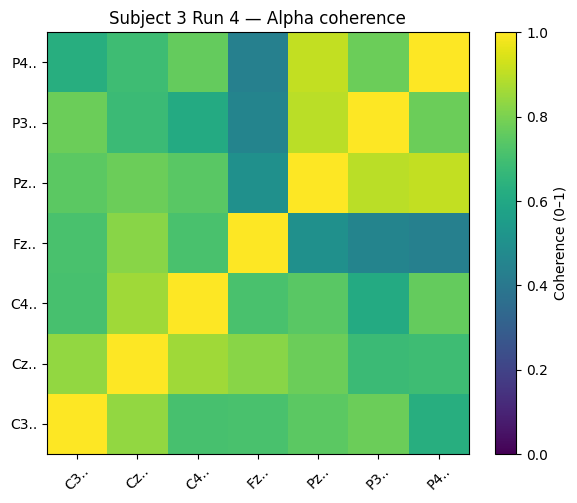

In [7]:
# Example: visualize subject 3, run 4
subj_example, run_example = 3, 4
alpha_coh, ch_labels = alpha_coh_all[(subj_example, run_example)]

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(alpha_coh, vmin=0, vmax=1, cmap='viridis', origin='lower')
ax.set_xticks(np.arange(len(ch_labels)))
ax.set_yticks(np.arange(len(ch_labels)))
ax.set_xticklabels(ch_labels, rotation=45)
ax.set_yticklabels(ch_labels)
ax.set_title(f"Subject {subj_example} Run {run_example} — Alpha coherence")
fig.colorbar(im, ax=ax, label='Coherence (0–1)')
plt.tight_layout()
plt.show()


In [8]:
matrices_run1 = []
matrices_run4 = []
valid_subjects = []
for subj in subjects:
    key1 = (subj, runs_to_fetch[0])
    key4 = (subj, runs_to_fetch[1])
    if key1 in alpha_coh_all and key4 in alpha_coh_all:
        m1, picks1 = alpha_coh_all[key1]
        m4, picks4 = alpha_coh_all[key4]
        # ensure channel order matches
        if picks1 != picks4:
            # Align columns/rows using picks4 order
            idx_map = [picks1.index(ch) for ch in picks4]
            m1 = m1[np.ix_(idx_map, idx_map)]
            picks = picks4
        else:
            picks = picks1
        matrices_run1.append(m1)
        matrices_run4.append(m4)
        valid_subjects.append(subj)
    else:
        print(f"Subject {subj} missing one of the runs; skipping.")

matrices_run1 = np.array(matrices_run1)  # shape: (n_subj, n_ch, n_ch)
matrices_run4 = np.array(matrices_run4)
n_subj = matrices_run1.shape[0]
n_ch = matrices_run1.shape[1]
print(f"Using {n_subj} subjects with {n_ch} channels: {picks}")

Using 5 subjects with 7 channels: ['C3..', 'Cz..', 'C4..', 'Fz..', 'Pz..', 'P3..', 'P4..']


In [11]:
# ---------- EDGE-WISE PAIRED T-TEST (run1 vs run4) ----------
# We'll vectorize upper-triangular edges (excluding diagonal).
triu_idx = np.triu_indices(n_ch, k=1)
n_edges = len(triu_idx[0])

# Build edge arrays: shape (n_subj, n_edges)
edges_run1 = matrices_run1[:, triu_idx[0], triu_idx[1]]
edges_run4 = matrices_run4[:, triu_idx[0], triu_idx[1]]
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import multipletests
# Paired t-test across subjects for each edge
t_stats, p_vals = ttest_rel(edges_run4, edges_run1, axis=0, nan_policy='omit')
# We'll compute mean difference and Cohen's d (paired)
mean_diff = (edges_run4 - edges_run1).mean(axis=0)
std_diff = (edges_run4 - edges_run1).std(axis=0, ddof=1)
cohens_d = mean_diff / (std_diff + 1e-12)

# FDR correction
reject_fdr, pvals_fdr, _, _ = multipletests(p_vals, alpha=0.05, method='fdr_bh')

# Prepare matrix of p-values and t-stats for visualization
t_mat = np.zeros((n_ch, n_ch)); p_mat = np.ones((n_ch, n_ch)); d_mat = np.zeros((n_ch, n_ch))
t_mat[triu_idx] = t_stats; t_mat = t_mat + t_mat.T
p_mat[triu_idx] = p_vals; p_mat = p_mat + p_mat.T
d_mat[triu_idx] = cohens_d; d_mat = d_mat + d_mat.T

# Significant edges after FDR
sig_edges_idx = np.where(reject_fdr)[0]
sig_edge_pairs = [(picks[triu_idx[0][i]], picks[triu_idx[1][i]]) for i in sig_edges_idx]
print(f"Edge-wise paired t-test: {len(sig_edges_idx)} edges pass FDR (alpha=0.05).")


Edge-wise paired t-test: 0 edges pass FDR (alpha=0.05).


In [13]:
def largest_component_size_from_t(t_vals, threshold, n_ch):
    """t_vals is 1D array of t-stat per upper tri edge; return size (#edges) of largest connected component."""
    # Build binary adjacency matrix
    bin_mat = np.zeros((n_ch, n_ch), dtype=int)
    bin_mat[triu_idx] = (np.abs(t_vals) >= threshold).astype(int)
    bin_mat = bin_mat + bin_mat.T
    G = nx.from_numpy_array(bin_mat)
    # remove isolated nodes
    comps = [c for c in nx.connected_components(G) if len(c) > 1]
    if not comps:
        return 0, []
    # For each component, count number of edges inside it
    comp_edge_counts = []
    comp_nodes_list = []
    for comp in comps:
        subg = G.subgraph(comp)
        comp_edge_counts.append(subg.number_of_edges())
        comp_nodes_list.append(list(comp))
    max_idx = np.argmax(comp_edge_counts)
    return comp_edge_counts[max_idx], comp_nodes_list[max_idx]

from scipy.stats import t

# number of subjects (we already have this)
df = n_subj - 1  # degrees of freedom for paired t-test
alpha = 0.05  # desired uncorrected significance level
t_thresh = t.ppf(1 - alpha/2, df)  # two-tailed threshold
print(f"t-threshold (two-tailed, alpha=0.05): {t_thresh:.3f}")



t-threshold (two-tailed, alpha=0.05): 2.776


In [18]:
import networkx as nx
# NBS permutation parameter (set this at top of script)
n_permutations = 500    # default: 500 (exploratory). Use 1000+ for reporting, 5000+ for publication-grade p-values.
random_state = 42
np.random.seed(random_state)

# Observed t-values per edge
t_obs = t_stats.copy()
obs_max_size, obs_nodes = largest_component_size_from_t(t_obs, t_thresh, n_ch)

# Permutation loop
max_sizes_null = np.zeros(n_permutations, dtype=int)
for perm in range(n_permutations):
    # For each subject, randomly swap labels with 50% probability (sign flip for paired test)
    # Equivalent to randomly multiply difference by +1 or -1
    signs = np.random.choice([1, -1], size=n_subj)
    diff = (edges_run4 - edges_run1) * signs[:, None]  # shape (n_subj, n_edges)
    # compute t-statistic under permuted signs: t = mean(diff) / (std(diff)/sqrt(n))
    denom = diff.std(axis=0, ddof=1) / np.sqrt(n_subj)
    denom[denom == 0] = np.finfo(float).eps
    t_perm = diff.mean(axis=0) / denom
    perm_max_size, _ = largest_component_size_from_t(t_perm, t_thresh, n_ch)
    max_sizes_null[perm] = perm_max_size

# p-value for observed component
p_nbs = (1 + np.sum(max_sizes_null >= obs_max_size)) / (1 + n_permutations)
print(f"NBS: observed largest component size = {obs_max_size} edges; NBS p-value = {p_nbs:.4f}")

NBS: observed largest component size = 1 edges; NBS p-value = 0.3433


In [19]:
# ---------- Visualize results ----------
# 1) Edge-wise FDR significant graph
G_fdr = nx.Graph()
G_fdr.add_nodes_from(picks)
for i in range(len(triu_idx[0])):
    if reject_fdr[i]:
        a = picks[triu_idx[0][i]]; b = picks[triu_idx[1][i]]
        weight = mean_diff[i]
        G_fdr.add_edge(a, b, weight=weight, t=t_stats[i], p=p_vals[i])

In [20]:
# 2) NBS component graph (if observed component non-zero)
G_nbs = nx.Graph()
G_nbs.add_nodes_from(picks)
if obs_max_size > 0:
    # get edges belonging to the observed component nodes (map node indices)
    comp_nodes = obs_nodes
    # convert numeric nodes to pick names
    comp_names = [picks[n] for n in comp_nodes]
    # add all edges between comp nodes that are supra-threshold in observed t
    for i in range(len(triu_idx[0])):
        if np.abs(t_obs[i]) >= t_thresh:
            n1 = triu_idx[0][i]; n2 = triu_idx[1][i]
            if (n1 in comp_nodes) and (n2 in comp_nodes):
                G_nbs.add_edge(picks[n1], picks[n2], weight=t_obs[i], t=t_obs[i], p=p_vals[i])

# Node positions: if MNE montage is available in previous raw, we try to use it; else circular layout
try:
    # try to get positions from a raw object (exists if compute step loaded last raw)
    pos2d = {}
    # we attempt to use 'raw' from last loop (if defined), else fallback
    if 'raw' in globals():
        montage = raw.get_montage()
        ch_pos = montage.get_positions()['ch_pos']
        for ch in picks:
            if ch in ch_pos:
                x,y,z = ch_pos[ch]
                pos2d[ch] = (x, y)
    if len(pos2d) != len(picks):
        raise Exception("Incomplete montage positions")
    pos = pos2d
except Exception:
    pos = nx.circular_layout(picks)

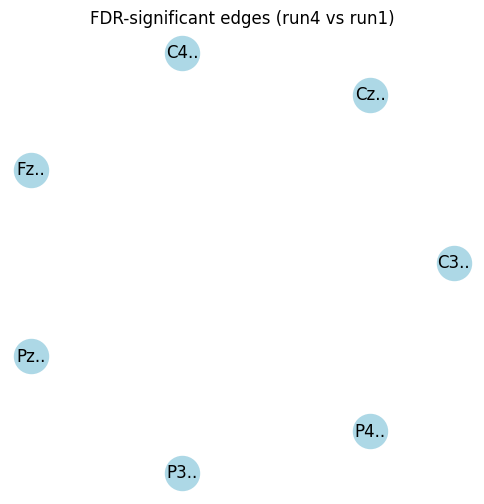

In [21]:
# Plot FDR graph
plt.figure(figsize=(6,6))
edge_weights = [abs(d['weight']) for (_,_,d) in G_fdr.edges(data=True)]
nx.draw_networkx_nodes(G_fdr, pos, node_color='lightblue', node_size=600)
if len(edge_weights) > 0:
    # scale widths
    widths = 2.0 * (np.array(edge_weights) / (np.max(edge_weights)+1e-12))
    nx.draw_networkx_edges(G_fdr, pos, width=widths)
nx.draw_networkx_labels(G_fdr, pos)
plt.title("FDR-significant edges (run4 vs run1)")
plt.axis('off')
plt.show()

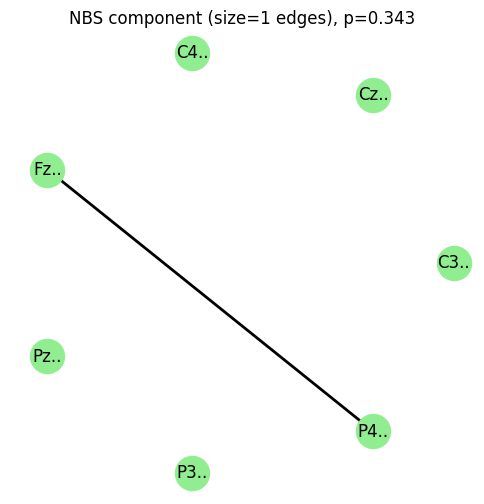

In [22]:
# Plot NBS component graph
if obs_max_size > 0:
    plt.figure(figsize=(6,6))
    edge_weights = [abs(d['weight']) for (_,_,d) in G_nbs.edges(data=True)]
    nx.draw_networkx_nodes(G_nbs, pos, node_color='lightgreen', node_size=600)
    if len(edge_weights)>0:
        widths = 2.0 * (np.array(edge_weights) / (np.max(edge_weights)+1e-12))
        nx.draw_networkx_edges(G_nbs, pos, width=widths)
    nx.draw_networkx_labels(G_nbs, pos)
    plt.title(f"NBS component (size={obs_max_size} edges), p={p_nbs:.3f}")
    plt.axis('off')
    plt.show()
else:
    print("No supra-threshold connected component found (at chosen t_thresh).")

In [23]:
# Show top 10 edges by absolute Cohen's d
abs_idx = np.argsort(np.abs(cohens_d))[::-1]
print("\nTop edges by effect size (Cohen's d):")
for k in range(min(10, len(abs_idx))):
    i = abs_idx[k]
    a = picks[triu_idx[0][i]]; b = picks[triu_idx[1][i]]
    print(f"{a}-{b}: d={cohens_d[i]:+.3f}, t={t_stats[i]:+.3f}, p={p_vals[i]:.4f}, FDR_sig={reject_fdr[i]}")


Top edges by effect size (Cohen's d):
Fz..-P4..: d=-1.278, t=-2.857, p=0.0461, FDR_sig=False
C3..-Fz..: d=+1.083, t=+2.422, p=0.0726, FDR_sig=False
Cz..-P4..: d=-0.931, t=-2.083, p=0.1057, FDR_sig=False
Pz..-P4..: d=-0.802, t=-1.793, p=0.1474, FDR_sig=False
Cz..-Pz..: d=-0.761, t=-1.701, p=0.1641, FDR_sig=False
Cz..-P3..: d=-0.707, t=-1.582, p=0.1888, FDR_sig=False
Cz..-Fz..: d=+0.701, t=+1.568, p=0.1920, FDR_sig=False
C3..-Cz..: d=+0.658, t=+1.471, p=0.2152, FDR_sig=False
Fz..-Pz..: d=-0.594, t=-1.329, p=0.2546, FDR_sig=False
C3..-P4..: d=-0.587, t=-1.313, p=0.2595, FDR_sig=False


In [24]:
# Summary
print("\nSummary:")
print(f"Subjects used: {valid_subjects}")
print(f"Total edges tested: {n_edges}")
print(f"Edges significant after FDR (alpha=0.05): {len(sig_edges_idx)}")
print(f"NBS observed component size: {obs_max_size}, NBS p = {p_nbs:.4f}")


Summary:
Subjects used: [1, 2, 3, 4, 5]
Total edges tested: 21
Edges significant after FDR (alpha=0.05): 0
NBS observed component size: 1, NBS p = 0.3433
